# sktime: Direct time series modelling

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

### Dataset

Unless otherwise stated, all results are done using the explicit time series version of the baseline dataset (ts_24).

In [2]:
# read Dataset as Pandas DataFrame
dataset = pd.read_pickle('../Dataset/baseline_dataset_tsnv_24.gz')
pd.set_option("display.max.columns", None)
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44837 entries, 0 to 44836
Data columns (total 68 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LOW_IMPACT     44837 non-null  bool   
 1   MID_IMPACT     44837 non-null  bool   
 2   BIG_IMPACT     44837 non-null  bool   
 3   DIRECT_STRIKE  44837 non-null  bool   
 4   MM00           44837 non-null  int32  
 5   DD00           44837 non-null  int32  
 6   HH00           44837 non-null  int32  
 7   MI_STATUS00    44837 non-null  bool   
 8   LI_STATUS00    44837 non-null  bool   
 9   SI_STATUS00    44837 non-null  bool   
 10  DS_STATUS00    44837 non-null  bool   
 11  DIST00         44837 non-null  float64
 12  AZM00          44837 non-null  float64
 13  SPEED00        44837 non-null  int32  
 14  DIR00          44837 non-null  int32  
 15  VMAX00         44837 non-null  int32  
 16  DVMAX00        44837 non-null  int32  
 17  MM06           44837 non-null  int32  
 18  DD06  

In [3]:
# imports
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split

# Constants
TRAIN_RATIO = 0.9

In [4]:
# test-dev-train split

def separateDataset(dataset, train_ratio):
    '''
    Takes in a dataset (pandas df) and a ratio value, returns a dictionary containing the separated dataset.
    Key "train" = train set, "dev" = dev set (size = train ratio * (sizeof input df - test set)), "test" = test set (size = train ratio * sizeof input df)
    '''
    train_dev_set, test_set = train_test_split(dataset, train_size=train_ratio, random_state=42)
    train_set, dev_set = train_test_split(train_dev_set, train_size=train_ratio, random_state=42)
    print("Training set size: {0}; Dev set size: {1}; Testing set size: {2}".format(len(train_set), len(dev_set), len(test_set)))
    return { "train": train_set, "dev": dev_set, "test": test_set }

def pandasToXY(dataframe):
    '''
    converts the given pandas df to X and Y sub-arrays. X is pandas df, Y is np int array.
    note: the range of columns to select as Y must be double checked when a different dataset is used.
    '''
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,0:4]).astype(int)
    return X, Y

# train-dev-test splitting
splitDataset = separateDataset(dataset, TRAIN_RATIO)
# separate each of the 3 sets into X and Y
train_full = splitDataset["train"]
train_X, train_Y = pandasToXY(train_full)
dev_full = splitDataset["dev"]
dev_X, dev_Y = pandasToXY(dev_full)
test_full = splitDataset["test"]
test_X, test_Y = pandasToXY(test_full)

Training set size: 36317; Dev set size: 4036; Testing set size: 4484


### Utilities

In [5]:
import joblib
from datetime import datetime

def save_sklearn_model_to_file(model, model_type, filename=None):
    '''Saves a sklearn model to file. Takes in the model, a name for the model and optionally a full filename.'''
    if filename == None:
        filename = "./models/baseline_model_{0}_{1}.skl".format(model_type, str(datetime.now().strftime("%Y-%m-%d %H-%M")))
        
    joblib.dump(model, filename)

In [6]:
#### FOR CLASSIFIERS
# convert predict_proba outputs of (n_targets, n_samples, 2) to (n_samples, n_classes)
def get_multioutput_proba(preds):
    '''Takes in a list of shape (n_targets, n_samples, 2) and converts it to np.array with shape (n_samples, n_targets)'''
    preds = np.array(preds)
    new_preds = []
    for i in range(4):
        new_preds.append(preds[i,:,1])
    new_preds = np.array(new_preds).T
    return new_preds

# finds the best decision thresholds and the corresponding F1 scores
# shows the precision-recall curve as well
def optimize_thresholds(clf, datasetX, datasetY):
    '''
    Takes in a classifier, an input set X and a target set Y; returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = clf.predict_proba(datasetX)
    if isinstance(clf, MultiOutputClassifier):
        all_preds = get_multioutput_proba(all_preds)
    best_thresholds = []
    best_f1_scores = []
    n_classes = 4
    for i in range(n_classes):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))
    
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
        
    return best_thresholds, best_f1_scores

# make predictions according to the given thresholds
def predictions_with_thresholds(clf, thresholds, datasetX):
    '''
    Takes in a classifier, a list of decision thresholds and an input samples set X;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = clf.predict_proba(datasetX)  
    if isinstance(clf, MultiOutputClassifier):
        preds_probs = get_multioutput_proba(preds_probs)
    n_classes = 4
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(n_classes):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [7]:
#### FOR REGRESSORS
from scipy.special import expit

def regression_predict(regr, datasetX, method='clip'):
    '''
    Takes in a regressor, an input samples set X and optionally a method argument (must be either "sigmoid" or "clip");
    Returns predictions made by the regressor on X that have been rescaled to fall within [0,1] using the specified method.
    '''
    # method specifies how to handle inputs outside of 0-1 range: clip to 0 or 1, or pass through sigmoid
    preds = regr.predict(datasetX)
    if method == 'clip':
        preds = np.clip(preds, 0, 1)
    elif method == 'sigmoid':
        preds = expit(preds)
    return preds

def regressor_find_thresholds(regr, datasetX, datasetY, method='clip'):
    '''
    Takes in a regressor, an input set X, a target set Y and optionally a scaling method;
    returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = regression_predict(regr, datasetX, method)
    best_thresholds = []
    best_f1_scores = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
    
    return best_thresholds, best_f1_scores

def regression_label(regr, datasetX, thresholds, method='clip'):
    '''
    Takes in a regressor, a list of decision thresholds, an input samples set X and optionally a scaling method;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = regression_predict(regr, datasetX, method)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(4):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

### Data Prepping

For TSNV_24 version of the baseline dataset, the last feature (DVMAX) cannot be kept because it has a missing value at the earliest time step.

In [8]:
PAST_TRACK_LIMIT = 24

def convert_X(dataset_X):
    '''Takes in a (n_samples, n_features) Pandas dataframe and returns it in shape (n_samples, n_features, time_series_length)'''
    processed_samples = 0
    new_dataset = []
    for index, row in dataset_X.iterrows():
        new_row = []

        # obtain time series for each feature        
        for i in range(12): # 10 for baseline_dataset_ts_24, 12 for tsnv
            feature_name = dataset_X.columns[i][:-2]
            feature_series = []
            for j in range(0, PAST_TRACK_LIMIT+6, 6):        
                feature_series.append(row.loc["{0}{1:02d}".format(feature_name, j)]) # access by column name
            feature_series.reverse() # newest data come last
            feature_series = pd.Series(data=feature_series) # correct type for each cell
            new_row.append(feature_series)

        # new_row = pd.Series(data=new_row, index=new_features)
        new_dataset.append(new_row)
        processed_samples += 1

        if processed_samples % 5000 == 0:
            print("Finished concatenating {0}/{1} samples...".format(processed_samples, dataset_X.shape[0]))

    # get new column names
    new_features = []
    for i in range(10):
            feature_name = dataset_X.columns[i][:-2]
            new_features.append(feature_name)
            
    # convert types back
    # converted_X = pd.DataFrame(new_dataset, columns=new_features)
    converted_X = np.array(new_dataset)
    print("Completed")
    return converted_X

train_X = convert_X(train_X)
dev_X = convert_X(dev_X)

Finished concatenating 5000/36317 samples...
Finished concatenating 10000/36317 samples...
Finished concatenating 15000/36317 samples...
Finished concatenating 20000/36317 samples...
Finished concatenating 25000/36317 samples...
Finished concatenating 30000/36317 samples...
Finished concatenating 35000/36317 samples...
Completed
Completed


In [9]:
from sktime.transformations.panel.compose import ColumnConcatenator

print("Before transform:", train_X.shape)
concat_train_X = ColumnConcatenator().fit_transform(train_X)
concat_dev_X = ColumnConcatenator().fit_transform(dev_X)
print("After transform:", concat_train_X.shape)
print("Each element is:", concat_train_X.iloc[0].iloc[0].shape)

Before transform: (36317, 12, 5)
After transform: (36317, 1)
Each element is: (60,)


In [10]:
# problem checking
X = np.asanyarray(concat_train_X)
if (X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum()) and not np.isfinite(X).all()):
    raise

for i in range(36317):
    if concat_train_X.iloc[i].iloc[0].isnull().values.any():
        print(i)
    if np.isinf(concat_train_X.iloc[i].iloc[0]).values.sum() > 0:
        print(i)    

### Classifiers
#### Time Series Forest

n_estimators=500: f1-score \[0.78655 0.77342 0.68837 0.71134\] average **0.73992**

same setting on tsnv_24: f1-score \[0.72778 0.67456 0.60145 0.53684\] average 0.63516 (600 => 0.64042, 700 => 0.64141, 800 => 0.68631)

#### Grid search hyperparameter optimization on tsnv set

best parameters: min_interval = 3; n_estimators = N/A (failed to fit)

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:50: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:51: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_MULTIINDEX_TYPES = (

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:50: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:51: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_MULTIINDEX_TYPES = (

Best Threshold=0.31213, F-Score=0.77165
Best Threshold=0.27000, F-Score=0.73288
Best Threshold=0.23604, F-Score=0.69430
Best Threshold=0.25600, F-Score=0.64062


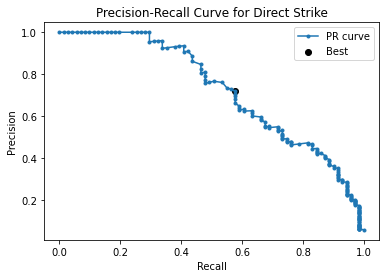

In [11]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn.multioutput import MultiOutputClassifier

tsfs_clf = TimeSeriesForestClassifier(min_interval=3, n_estimators=500, n_jobs=-1)
tsfs_clf = MultiOutputClassifier(tsfs_clf, n_jobs=-1).fit(concat_train_X, train_Y)
best_thresholds, best_f1_scores = optimize_thresholds(tsfs_clf, concat_dev_X, dev_Y)

In [12]:
preds = predictions_with_thresholds(tsfs_clf, best_thresholds, concat_dev_X)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.75711   0.78342   0.77004       374
           1    0.67192   0.80075   0.73070       266
           2    0.66000   0.71739   0.68750        92
           3    0.72727   0.56338   0.63492        71

   micro avg    0.71246   0.76214   0.73646       803
   macro avg    0.70408   0.71624   0.70579       803
weighted avg    0.71513   0.76214   0.73561       803
 samples avg    0.08158   0.08699   0.08141       803



In [13]:
save_sklearn_model_to_file(tsfs_clf, "tsfs_clf")

In [23]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline

param_grid = {"clf__estimator__n_estimators": [100,200,300,400,500,600,700]}
estimator = MultiOutputClassifier(TimeSeriesForestClassifier(min_interval=3, n_jobs=-1, random_state=42), n_jobs=-1)

steps = [
    ('cc', ColumnConcatenator()), ('clf', estimator)
]
pipe = Pipeline(steps, verbose=True)

scorer = make_scorer(f1_score, zero_division=0, average='macro')

gscv = GridSearchCV(pipe, param_grid, scoring=scorer, n_jobs=-1, verbose=2, cv=3).fit(train_X, train_Y)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2131, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2140, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/userhome/cs/u3556490/anaconda3/envs/tes

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2131, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2140, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/userhome/cs/u3556490/anaconda3/envs/tes

[Pipeline] ................ (step 1 of 2) Processing cc, total=   1.9s
[CV] END ...................clf__estimator__n_estimators=300; total time=   2.2s
[Pipeline] ................ (step 1 of 2) Processing cc, total=  13.4s
[CV] END ...................clf__estimator__n_estimators=300; total time=17.8min
[Pipeline] ................ (step 1 of 2) Processing cc, total=   2.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=17.3min
[CV] END ...................clf__estimator__n_estimators=300; total time=19.3min


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2131, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2140, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/userhome/cs/u3556490/anaconda3/envs/tes

[Pipeline] ................ (step 1 of 2) Processing cc, total=   2.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 9.6min
[CV] END .....................clf__estimator__min_interval=2; total time=10.9min
[Pipeline] ................ (step 1 of 2) Processing cc, total=   2.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 5.8min
[CV] END ...................clf__estimator__n_estimators=100; total time= 6.2min
[Pipeline] ................ (step 1 of 2) Processing cc, total=   8.2s
[CV] END ...................clf__estimator__n_estimators=400; total time=   8.8s
[Pipeline] ................ (step 1 of 2) Processing cc, total=   7.8s
[Pipeline] ............... (step 2 of 2) Processing clf, total=22.8min
[CV] END ...................clf__estimator__n_estimators=400; total time=23.0min


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 21.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2131, in pandas._libs.hashtable.Int64HashTable.get_ite

[Pipeline] ................ (step 1 of 2) Processing cc, total=   2.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.1min


In [24]:
gscv.cv_results_

{'mean_fit_time': array([ 355.15578612,  665.97438931,  704.10265954,  463.84502514,
         532.99956807, 1041.96243707, 1001.49752259]),
 'std_fit_time': array([  6.0655822 ,   5.68811689, 496.43922866, 644.4328835 ,
        713.21950171, 730.62968049, 698.94236016]),
 'mean_score_time': array([37.73333263, 36.27161781, 38.44621062,  1.09211246, 33.39058812,
        20.59077764, 22.03547589]),
 'std_score_time': array([14.31955449, 41.47378944, 54.37115248,  1.54448026, 47.22142258,
        29.11975699, 31.16286886]),
 'param_clf__estimator__n_estimators': masked_array(data=[100, 200, 300, 400, 500, 600, 700],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__estimator__n_estimators': 100},
  {'clf__estimator__n_estimators': 200},
  {'clf__estimator__n_estimators': 300},
  {'clf__estimator__n_estimators': 400},
  {'clf__estimator__n_estimators': 500},
  {'clf__estimator__n_estimators': 600},
 

[Pipeline] ................ (step 1 of 2) Processing cc, total=   2.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 9.6min
[CV] END .....................clf__estimator__min_interval=3; total time=10.9min
[Pipeline] ................ (step 1 of 2) Processing cc, total=   1.9s
[Pipeline] ............... (step 2 of 2) Processing clf, total=11.1min
[CV] END ...................clf__estimator__n_estimators=200; total time=11.2min
[Pipeline] ................ (step 1 of 2) Processing cc, total=  11.7s
[CV] END ...................clf__estimator__n_estimators=600; total time=  13.1s
[Pipeline] ................ (step 1 of 2) Processing cc, total=  17.2s
[Pipeline] ............... (step 2 of 2) Processing clf, total=25.4min
[CV] END ...................clf__estimator__n_estimators=700; total time=26.8min
[Pipeline] ................ (step 1 of 2) Processing cc, total=   2.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 9.7min
[CV] END .....................clf__es

The remainder of the possible models take an excessively long time to run and are better left overnight like a proper pizza dough.

#### Dictionary-based
Takes long to fit (seems threads are oftentimes waiting for each other) and perhaps is not a good fit.

IndividualBOSS: didn't converge within 30 minutes, when left to run overnight, f1-scores \[0.39503 0.39721 0.24272 0.04688\]

MUSE: converged in 2h, f1-scores \[0.56445 0.55512 0.34831 0.28777 \] average 0.43891

#### Distance-based
ElasticEnsemble: runtime error and failed to fit

ProximityTree: out of memory error

ProximityForest: out of memory error

KNeighborsTimeSeriesClassifier: 6 hours to converge, f1-scores \[0.66882 0.64557 0.56388 0.51429\] average 0.59814

#### Kernel-based
Arsenal: out of memory error

#### Interval-based
DrCIF: did not converge within 20 hours

#### Shapelet-based
ShapeletTransformClassifier: cannot converge in 17 hours

### Regressor

What a shame, they only provide one regressor model.

#### Time Series Forest (Regressor version)
This one is basically the same as the classifier version.

(TS) n_estimators=500: f1-score \[0.79110 0.77281 0.66298 0.59259\] average 0.70487  
(TSNV): 0.67112

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:50: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Ind

[CV 3/3] END ....................min_interval=2;, score=0.632 total time= 1.8min
[CV 2/3] END ....................min_interval=5;, score=0.624 total time= 1.8min
[CV 1/3] END ..................n_estimators=200;, score=0.632 total time= 1.4min
[CV 3/3] END ..................n_estimators=400;, score=0.640 total time= 3.8min
[CV 3/3] END ..................n_estimators=450;, score=0.637 total time= 4.6min
[CV 2/3] END ..................n_estimators=600;, score=0.608 total time= 6.0min
[CV 3/3] END ..................n_estimators=650;, score=0.644 total time= 6.9min
[CV 3/3] END ....................min_interval=3;, score=0.642 total time= 2.0min
[CV 2/3] END ....................min_interval=6;, score=0.607 total time= 1.4min
[CV 1/3] END ..................n_estimators=300;, score=0.641 total time= 2.9min
[CV 3/3] END ..................n_estimators=500;, score=0.638 total time= 2.6min
[CV 3/3] END ..................n_estimators=500;, score=0.641 total time= 5.5min
[CV 2/3] END ...............

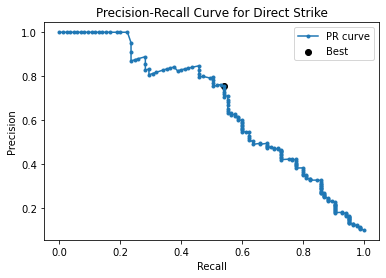

In [21]:
from sktime.regression.interval_based import TimeSeriesForestRegressor

tsfs_regr = TimeSeriesForestRegressor(n_estimators=700, min_interval=3, n_jobs=-1)
tsfs_regr = tsfs_regr.fit(concat_train_X, train_Y)
best_thresholds, best_f1_scores = regressor_find_thresholds(tsfs_regr, concat_dev_X, dev_Y)

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.041785
Class 1, no calibration: 0.031888
Class 2, no calibration: 0.014922
Class 3, no calibration: 0.012978


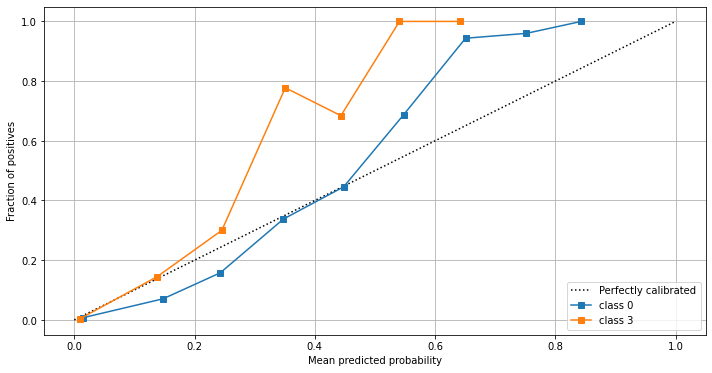

In [22]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec

all_preds = tsfs_regr.predict(concat_dev_X)

print("Brier score losses: (the smaller the better)")
for i in range(4):
    preds = all_preds[:,i]
    clf_score = brier_score_loss(dev_Y[:,i], preds)
    print("Class {0}, no calibration: {1:1.6f}".format(i, clf_score))

# plot calibration graphs
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
ax = fig.add_subplot(gs[:2, :2])

preds = all_preds
preds = preds[:,0]
display = CalibrationDisplay.from_predictions(dev_Y[:,0], preds, n_bins=10, name="class 0", ax=ax, strategy='uniform')
preds = all_preds
preds = preds[:,3]
display = CalibrationDisplay.from_predictions(dev_Y[:,3], preds, n_bins=10, name="class 3", ax=ax, strategy='uniform')

ax.grid()
plt.tight_layout()
plt.show()

In [23]:
preds = regression_label(tsfs_regr, concat_dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.70950   0.69022   0.69972       368
           1    0.68929   0.67483   0.68198       286
           2    0.74713   0.57522   0.65000       113
           3    0.76271   0.52941   0.62500        85

   micro avg    0.71046   0.65376   0.68093       852
   macro avg    0.72716   0.61742   0.66418       852
weighted avg    0.71301   0.65376   0.67972       852
 samples avg    0.07788   0.07807   0.07499       852



In [20]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_recall_curve

param_grid = {"n_estimators": [650, 700, 750]}

estimator = TimeSeriesForestRegressor(min_interval=3, n_jobs=-1)

def my_scorer(y_true, y_pred):
    '''Returns the average f1 scores for the given label y_true and continuous y_pred.'''
    y_pred = np.clip(y_pred, 0, 1)
    best_thresholds = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(y_true[:,i], y_pred[:,i])
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
    preds = []
    for i in range(len(y_pred)):
        pred_row = []
        for j in range(4):
            if y_pred[i,j] > best_thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    return f1_score(y_true, preds, zero_division=0, average='macro')

scorer = make_scorer(my_scorer)

gscv = GridSearchCV(estimator, param_grid, scoring=scorer, verbose=4, cv=3, n_jobs=-1, refit=False).fit(concat_train_X, train_Y)

print(gscv.cv_results_)
print(gscv.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:50: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:51: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_MULTIINDEX_TYPES = (

{'mean_fit_time': array([354.07047319, 406.1199433 , 321.33089534]), 'std_fit_time': array([ 14.20486594,   4.38912741, 132.98940652]), 'mean_score_time': array([47.2736915 , 37.92480262, 20.20798826]), 'std_score_time': array([3.79602255, 1.7601201 , 6.04005473]), 'param_n_estimators': masked_array(data=[650, 700, 750],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 650}, {'n_estimators': 700}, {'n_estimators': 750}], 'split0_test_score': array([0.63250329, 0.63697271, 0.63384435]), 'split1_test_score': array([0.61322758, 0.61916981, 0.61524021]), 'split2_test_score': array([0.64403687, 0.64510593, 0.64144524]), 'mean_test_score': array([0.62992258, 0.63374949, 0.6301766 ]), 'std_test_score': array([0.01270953, 0.0108309 , 0.01100803]), 'rank_test_score': array([3, 1, 2], dtype=int32)}
{'n_estimators': 700}


In [24]:
save_sklearn_model_to_file(tsfs_regr, "tsfs_regr")

[CV 2/3] END ..................n_estimators=750;, score=0.615 total time= 7.2min
[CV 2/3] END ....................min_interval=2;, score=0.606 total time= 1.5min
[CV 1/3] END ....................min_interval=5;, score=0.626 total time= 1.8min
[CV 3/3] END ..................n_estimators=100;, score=0.622 total time=  33.7s
[CV 2/3] END ..................n_estimators=400;, score=0.613 total time= 4.0min
[CV 2/3] END ..................n_estimators=450;, score=0.616 total time= 4.4min
[CV 1/3] END ..................n_estimators=600;, score=0.641 total time= 6.0min
[CV 2/3] END ..................n_estimators=650;, score=0.613 total time= 6.7min
[CV 2/3] END ....................min_interval=3;, score=0.607 total time= 1.9min
[CV 1/3] END ....................min_interval=6;, score=0.628 total time= 1.6min
[CV 3/3] END ..................n_estimators=200;, score=0.630 total time= 1.6min
[CV 2/3] END ..................n_estimators=500;, score=0.614 total time= 3.8min
[CV 2/3] END ...............

### Forecasters
Glorified line-fitting methods and others galore. The sad part is that the routines run single-threaded and will take quite a while.

TrendForecaster: Best Threshold=\[0.16667 0.16667 1.00000 1.00000\], F-Score=\[0.46384 0.44940 0.30626 0.21687\]

PolynomialTrendForecaster: Best Threshold=\[0.08333 0.08333 0.08333 0.08333\], F-Score=\[0.39911 0.37492 0.25260 0.20986\]

NaiveForecaster: Best Threshold=\[1.00000 1.00000 1.00000 1.00000\], F-Score=\[0.46843 0.42102 0.32064 0.23390\]

ThetaForecaster: Best Threshold=\[0.50000 0.08333 0.25000 1.00000\], F-Score=\[0.46324 0.44876 0.30691 0.21687\]

ExponentialSmoothing: Best Threshold=\[1.00000 1.00000 1.00000 1.00000\], F-Score=\[0.43868 0.45170 0.27720 0.19798\]

And the other sad thing is they don't perform well, which is explicable because we only have a time series with 5 time steps in total. Also, many of these guys cannot take exogenous variables into account well.

In [31]:
# next 72 hours = the last of the next 12 intervals (each 6 hours apart)
HORIZON = list(range(1,13,1))

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import TrendForecaster, PolynomialTrendForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.theta import ThetaForecaster

In [32]:
def fetch_forecasts(model, dataset_X, verbose=False):
    '''
    Takes in a forecaster, a input dataset and a verbosity switch; fits the forecaster to each sample in the dataset 
    and returns the corresponding predictions in (n_sample, n_classes) numpy array.
    '''
    all_preds = []
    for i in range(len(dataset_X)):
        time_series = dataset_X[i].T
        raw_preds = []
        for j in range(3,7):
            targets = pd.DataFrame(time_series[:,j])
            exogenous = pd.DataFrame(time_series[:, [0,1,2,7,8,9]]) # this bit may vary in the future...
            model.fit(y=targets, X=exogenous)
            preds = np.array(model.predict(fh=HORIZON))
            preds = preds.reshape(len(HORIZON))
            raw_preds.append(preds)
        raw_preds = expit(np.array(raw_preds))
        all_preds.append((np.sum(raw_preds.round(), axis=1) / len(HORIZON)))
        
        if i % 2000 == 0 and verbose:
            print("Completed {0}/{1} samples".format(i, len(dataset_X)))

    return np.array(all_preds)

In [14]:
def forecast_pr_curve(model, dataset_X, dataset_Y, preds=None):
    '''
    Takes in a forecaster, input dataset X and target Y, and optionally a pre-computed list of predictions (to save computation time);
    calculates the forecasts (if not already available) and uses precision-recall curves to find the best decision thresholds;
    returns the best thresholds and the corresponding F1-scores.
    '''
    if preds is None:
        all_preds = fetch_forecasts(model, dataset_X, False)
    else:
        all_preds = preds
    best_thresholds = []
    best_f1_scores = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(dataset_Y[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
    
    return best_thresholds, best_f1_scores

def deterministic_forecast(model, dataset_X, thresholds, given_preds=None):
    '''
    Takes in a forecaster, input dataset X, list of decision thresholds, and optionally a pre-computed list of predictions (to save computation time);
    Returns deterministic forecasts generated using the model (if not already pre-computed the probs) and the given thresholds.
    '''
    if given_preds is None:
        preds_probs = fetch_forecasts(model, dataset_X, False)
    else:
        preds_probs = given_preds
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(4):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [ ]:
fc = ThetaForecaster(deseasonalize=False)
preds = fetch_forecasts(fc, train_X, True)

Best Threshold=0.50000, F-Score=0.45844
Best Threshold=0.08333, F-Score=0.44952
Best Threshold=1.00000, F-Score=0.28864
Best Threshold=1.00000, F-Score=0.21103


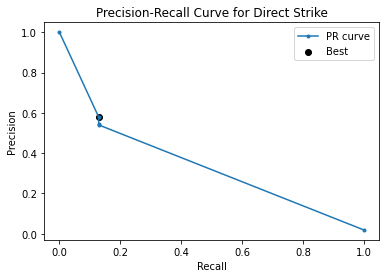

In [35]:
best_thresholds, best_f1_scores = forecast_pr_curve(fc, train_X, train_Y, preds)
det_preds = deterministic_forecast(fc, train_X, best_thresholds, preds)

In [39]:
print(classification_report(train_Y, det_preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.86838   0.30919   0.45601      3286
           1    0.84624   0.30587   0.44933      2537
           2    0.00000   0.00000   0.00000       945
           3    0.00000   0.00000   0.00000       682

   micro avg    0.85865   0.24054   0.37580      7450
   macro avg    0.42865   0.15377   0.22634      7450
weighted avg    0.67119   0.24054   0.35415      7450
 samples avg    0.04619   0.03454   0.03749      7450

